In [9]:
import torch
import torchio as tio
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
import pandas as pd
import os
import pyvista as pv
import nibabel as nib
import SimpleITK as sitk
from IPython.display import Image, display
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv("UCSF-PDGM-metadata_v5.csv")

df.head()

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training


In [3]:
new_df = df[['ID', "IDH"]].copy()

new_df.head()

,ID,IDH
0,UCSF-PDGM-004,wildtype
1,UCSF-PDGM-005,wildtype
2,UCSF-PDGM-007,wildtype
3,UCSF-PDGM-008,wildtype
4,UCSF-PDGM-009,wildtype


In [4]:
new_df['IDH_binary'] = (new_df['IDH'] != 'wildtype').astype(int)

final_df = new_df.drop(['IDH'], axis=1)

print("Final version:")
print(final_df['IDH_binary'].value_counts())

print('-' * 30)
final_df.head()

Final version:
IDH_binary
0    398
1    103
Name: count, dtype: int64
------------------------------


,ID,IDH_binary
0,UCSF-PDGM-004,0
1,UCSF-PDGM-005,0
2,UCSF-PDGM-007,0
3,UCSF-PDGM-008,0
4,UCSF-PDGM-009,0


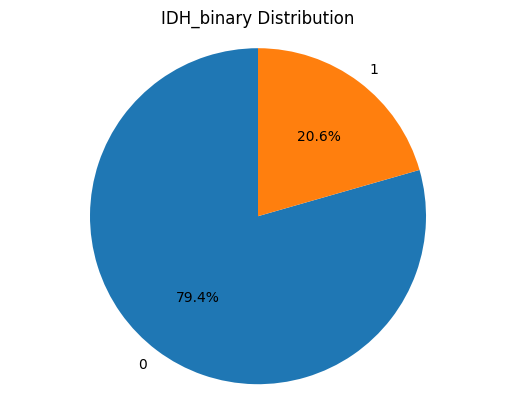

In [5]:
counts = final_df['IDH_binary'].value_counts()

plt.pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('IDH_binary Distribution')
plt.axis('equal')
plt.show()

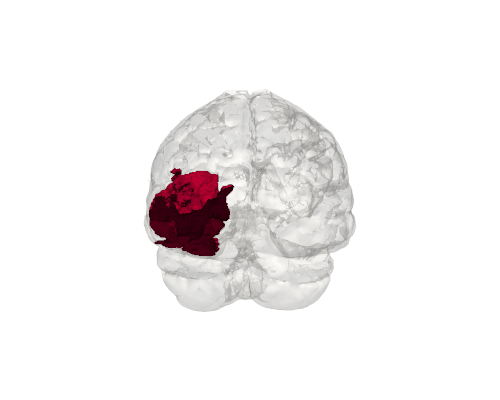

In [6]:
base_path = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5/UCSF-PDGM-0032_nifti/"

mri_filename = "UCSF-PDGM-0032_FLAIR_bias.nii.gz"
mri_filepath = os.path.join(base_path, mri_filename)

tumor_mask_filename = "UCSF-PDGM-0032_tumor_segmentation.nii.gz"
tumor_mask_filepath = os.path.join(base_path, tumor_mask_filename)

mri_img = nib.load(mri_filepath)
mri_data = mri_img.get_fdata()

tumor_mask_img = nib.load(tumor_mask_filepath)
tumor_mask_data = tumor_mask_img.get_fdata()

mri_grid = pv.wrap(mri_data)
tumor_grid = pv.wrap(tumor_mask_data)


brain_surface = mri_grid.contour([300]).smooth(n_iter=50, relaxation_factor=0.1)
tumor_surface = tumor_grid.contour([0.5]).smooth(n_iter=30)

plotter = pv.Plotter(off_screen=True, window_size=[500, 400])

plotter.add_mesh(brain_surface, color="white", opacity=0.2, specular=0.3, specular_power=10)
plotter.add_mesh(tumor_surface, color="#c70039", opacity=1.0)
plotter.enable_shadows()

plotter.camera_position = 'iso'

output_filename = "brain_tumor_3rd_person_view.gif"

path = plotter.generate_orbital_path(n_points=72)
plotter.open_gif(output_filename)
plotter.orbit_on_path(path, write_frames=True)
plotter.close()

display(Image(filename=output_filename))

In [14]:
train_df, temp_df = train_test_split(final_df, test_size = 0.3, random_state=42, stratify=final_df['IDH_binary'])

val_df, test_df = train_test_split(temp_df, test_size = 0.5, random_state=42, stratify=temp_df['IDH_binary'])

In [7]:
def inspect_single_mri_scan(patient_folder_path, mri_filename):
    
    full_mri_path = os.path.join(patient_folder_path, mri_filename)

    print(f"--- Inspecting File: {full_mri_path} ---")

    if not os.path.exists(full_mri_path):
        print(f"Error: File not found at the specified path.")
        return

    try:
        image = sitk.ReadImage(full_mri_path)
        print("Successfully loaded the image.")
    except Exception as e:
        print(f"An error occurred while trying to read the file: {e}")
        return


    size = image.GetSize()
    print(f"Original Size (in voxels): {size}")

    spacing = image.GetSpacing()
    print(f"Original Spacing (in mm): {spacing}")
    
    print("-------------------------------------------\n")


base_data_directory = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5"


patient_folder_name = "UCSF-PDGM-0520_nifti"

patient_id = patient_folder_name.replace("_nifti", "")

patient_folder_path = os.path.join(base_data_directory, patient_folder_name)

core_files = [
    f"{patient_id}_t1.nii.gz",
    f"{patient_id}_t1c.nii.gz",
    f"{patient_id}_t2.nii.gz",
    f"{patient_id}_flair.nii.gz",
    f"{patient_id}_tumor_segmentation.nii.gz"
]

if not os.path.isdir(patient_folder_path):
        print(f"Error: The patient folder was not found at: {patient_folder_path}")
        print("Please check the 'base_data_directory' and 'patient_folder_name' variables.")
else:
    for filename in core_files:
        inspect_single_mri_scan(patient_folder_path, filename)


--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t1c.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_t2.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)
Original Spacing (in mm): (1.0, 1.0, 1.0)
-------------------------------------------

--- Inspecting File: PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5\UCSF-PDGM-0520_nifti\UCSF-PDGM-0520_flair.nii.gz ---
Successfully loaded the image.
Original Size (in voxels): (240, 240, 155)

In [8]:
def resample_image(image, target_size = (224,224,128), is_segmentation=False):

    original_size = image.GetSize()
    original_spacing = image.GetSpacing()

    new_spacing = [
        original_spacing[0] * (original_size[0] / target_size[0]),
        original_spacing[1] * (original_size[1] / target_size[1]),
        original_spacing[2] * (original_size[2] / target_size[2])
    ]

    interpolator = sitk.sitkLinear
    if is_segmentation:
        interpolator = sitk.sitkNearestNeighbor

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(target_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(interpolator)

    resampled_image = resampler.Execute(image)

    image_array = sitk.GetArrayFromImage(resampled_image)

    return image_array

In [ ]:
class UCSFDataset(Dataset):
    def __init__(self, root_dir, labels_df, modalities, transform=None):
        self.root_dir = root_dir
        self.labels_df = labels_df
        self.modalities = modalities
        self.transform = transform
        self.subject_folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.subject_folders)

    def __getitem__(self, idx):
        subject_folder = self.subject_folders[idx]
        subject_id = subject_folder.replace("_nifti","")
        prefix, number_part = subject_id.rsplit('-', 1)
        modified_number = number_part[1:]
        label_id = f"{prefix}-{modified_number}"
        specific_row = self.labels_df[self.labels_df["ID"] == label_id]
        label = specific_row["IDH_binary"].values[0]
        input_modalities = []
        for modality in self.modalities:
            filename = f"{subject_id}_{modality}.nii.gz"
            filepath = os.path.join(self.root_dir, subject_folder, filename)
            image = sitk.ReadImage(filepath)
            resampledImage = resample_image(image, (224,224,128))
            input_modalities.append(resampledImage)
        stacked_images = np.stack(input_modalities, axis = 0)
        image_tensor = torch.from_numpy(stacked_images).float()
        label_tensor = torch.tensor(label, dtype=torch.long)
        if self.transform:
            final_image_tensor = self.transform(image_tensor)
            return final_image_tensor, label_tensor
            
           
        return image_tensor, label_tensor

test_transform = tio.Compose([
    tio.ZNormalization(),
])

train_transform = tio.Compose([
    tio.ZNormalization(),

    tio.RandomFlip(axes=('LR'), flip_probability=0.5),

    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=10,
        isotropic=False,
    ),
])

modalities = ["FLAIR_bias",
              "T1c_bias",
              "T2_bias",
              "T1_bias"]

trainDataset = UCSFDataset(root_dir = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", train_df, modalities, transform=train_transform)
testDataset = UCSFDataset(root_dir = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", test_df, modalities, transform=test_transform)
valDataset = UCSFDataset(root_dir = "PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5", val_df, modalities, transform=test_transform)

labels = []

for i in range(len(traindataset)):
    _, label_tensor = traindataset[i]
    labels.append(label_tensor.item())

class_counts = Counter(labels)
class_weights = {cls:1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]
sample_weights = torch.DoubleTensor(sample_weights)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

trainLoader = DataLoader(traindataset, batch_size=16, sampler=sampler, shuffle = True)
testLoader = DataLoader(testDataset, batch_size=16)
trainLoader = DataLoader(valDataset, batch_size=16)